In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op

In [2]:
Msun=cte.M_sun
c=cte.c
b=2

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [4]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=c/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [5]:
frecs0T=[v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]]
errf0T=[ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]]

In [6]:
frecs0=np.array([[v1[0],v2[0],v3[0]],[l1[0],l2[0],l3[0]]])
errf0=np.array([[ev1[0],ev2[0],ev3[0]],[el1[0],el2[0],el3[0]]])

In [7]:
def tau(z,b,M_,d_,vf,v0): 
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [8]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [9]:
def modelSv(z,T,b,M_,d_,vf,v0):
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,b,M_,d_,vf,v0))*P(vf,T,z)
    Sv=S_.to("mJy")   
    return Sv.value

MCMC
This will show how you might use informative priors.

Let's make sure it knows that the dust needs to be warmer than the CMB and that the amplitude needs to be positive.

Also, "normal" galaxies have dust temperatures of ~25 K, with a dispersion of a few 2K. Let's set the prior on temperature to be a Gaussian centered at 25 K with a sigma of 2.5K.

In [13]:
z0=3.3
T0=56*un.K
M0_=9.45
d0_=2.9*un.kpc
Tc0=45.9*un.K

In [10]:
def lnlike(lnf,z,T,b,M_,d_,vf,v0,y, yerr):
    model = modelSv(z,T,b,M_,d_,vf,v0)
    inv_sigma2 = 1.0 / (yerr**2 + (model*un.mJy)**2 * np.exp(2*lnf))
    print(inv_sigma2)
    return -0.5 * np.sum((y-(model*un.mJy))**2*inv_sigma2 - np.log(inv_sigma2.value))

In [14]:
lnlike(-1,z0,T0,2,M0_,d0_,vf*un.Hz,353*un.Hz,frecs0T*un.mJy, errf0T*un.mJy)

[0.02161355 0.00642663 0.00253725 0.00066027 0.0006045  0.00103497] 1 / mJy2


<Quantity -20.56152664>

In [15]:
def lnprior(T):
    print(T)
    if T >= 2.73:
        return -1 * (T - 25)**2 / (2 * 2.5**2)
    return -np.inf

In [16]:
def lnprob(lnf,z,T,b,M_,d_,vf,v0,y, yerr):
    lp = lnprior(T)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(lnf,z,T,b,M_,d_,vf,v0,y, yerr)

ACT-S J0011-0018

In [17]:
(np.array(errf0T)*un.mJy)**2

<Quantity [ 4.9729,  9.6721, 94.8676, 54.9081, 40.0689, 52.5625] mJy2>

In [18]:
lnlike(-1,z0,T0,b,M0_,d0_,vf*un.Hz,350*un.GHz, np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy)

[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2


<Quantity -17.12440462>

In [19]:
lnprob(-1,z0,T0.value,b,M0_,d0_,vf*un.Hz,350*un.GHz,np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy)

56.0
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2


<Quantity -94.00440462>

In [20]:
# initial guesses. 25K, arbitrary 
p0 = [-1,3.3,56,2,9.45,2.9]
args=(vf*un.Hz,np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy)
nll = lambda *args: -lnlike(-1,z0,T0,b,M0_,d0_,vf*un.Hz,350*un.GHz, np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy)
maxlike = op.minimize(nll, p0,args)
lnf0_fit,z0_fit,T0_fit,b_fit,M0_fit,d0_fit = maxlike["x"]

[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2


In [25]:
print(lnf0_fit,z0_fit,T0_fit,b_fit,M0_fit,d0_fit) # aquí se nota que los valores de ML son iguales que los ingresados

-1.0 3.3 56.0 2.0 9.45 2.9


In [21]:
modelSv(z0,T0,b,M0_,d0_,vf*un.Hz,(353*un.GHz))*un.mJy

<Quantity [  6.15510335,  20.0429737 ,  36.87010356, 103.76908774,
           109.21273591,  82.16468646] mJy>

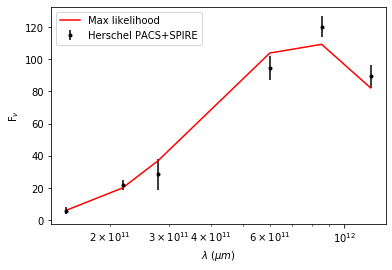

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(vf,np.array(frecs0T), np.array(errf0T),
            ls='',
            marker='.',
            color='black',
            label='Herschel PACS+SPIRE')
ax.plot(vf,modelSv(z0,T0,b,M0_,d0_,vf*un.Hz,(353*un.GHz)),
        color='red',
        label='Max likelihood')
ax.set_ylabel(r'F$_{\nu}$')
ax.set_xlabel('$\lambda$ ($\mu m$)')
ax.set_xscale('log')
ax.legend(loc='best')

In [23]:
ndim, nwalkers = 6, 300
pos = [maxlike["x"] + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
pos

[array([-1.00010603,  3.29981327, 56.00004415,  1.99997657,  9.44997743,
         2.89993664]),
 array([-0.99997293,  3.29997384, 55.99988849,  2.00004017,  9.45006142,
         2.90005675]),
 array([-1.00011211,  3.29992998, 55.9999745 ,  2.0000379 ,  9.45017968,
         2.9000697 ]),
 array([-0.99997033,  3.30002219, 56.00003131,  1.99992432,  9.45002315,
         2.89986498]),
 array([-0.99996668,  3.29988796, 56.00024008,  2.00004484,  9.44991802,
         2.8997781 ]),
 array([-0.9999962 ,  3.29998976, 56.00012305,  2.00000884,  9.45006299,
         2.90003258]),
 array([-0.99987263,  3.29982007, 56.0000274 ,  1.99997303,  9.45001623,
         2.89995285]),
 array([-0.99996124,  3.30010209, 55.99979211,  1.99989519,  9.45004864,
         2.89990216]),
 array([-1.00005986,  3.30011988, 56.00010436,  2.00006034,  9.44997718,
         2.89999408]),
 array([-1.00002238,  3.30000781, 55.99997484,  1.99983836,  9.44999795,
         2.90015356]),
 array([-1.00001746,  3.30012708, 55.999

In [24]:
nthreads=2


In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,lnprob(-1,z0,T0.value,b,M0_,d0_,vf*un.Hz,350*un.GHz,np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy) ,
                                args=(vf*un.Hz,np.array(frecs0T) *un.mJy, np.array(errf0T)*un.mJy),
                                threads=nthreads)

sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

56.0
[0.09764179 0.01534635 0.0035525  0.00066117 0.0006045  0.00103497] 1 / mJy2
emcee: Exception while calling your likelihood function:
  params: [-1.00010603  3.29981327 56.00004415  1.99997657  9.44997743  2.89993664]
  args: (<Quantity [1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
           8.56549880e+11, 1.19916983e+12] Hz>, <Quantity [  6.02,  21.93,  28.43,  94.65, 120.18,  89.41] mJy>, <Quantity [2.23, 3.11, 9.74, 7.41, 6.33, 7.25] mJy>)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: 'Quantity' object is not callable


TypeError: 'Quantity' object is not callable